<a href="https://colab.research.google.com/github/nicoussj/MachineLearning/blob/main/%C3%81rbol_de_decisi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [21]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
import graphviz

# Configuraciones para gráficos
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Ignorar advertencias
warnings.filterwarnings('ignore')

##Dataset

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=";", encoding='latin1', header=0)

df.columns = df.columns.str.replace(';', '')

df.head(10)

df = df.dropna()
df['RoundStartingEquipmentValue'] = df['RoundStartingEquipmentValue'].fillna(df['RoundStartingEquipmentValue'].median())
df = pd.get_dummies(df, columns=['Map'], drop_first=True)
#Cambio de datos: Cambiar de False4 en RoundWinner a False, agregar False a MatchWinner, ya que en contexto aplica
df.loc[29,'MatchWinner'] = 'False'
df.loc[29,'RoundWinner'] = 'False'
#Se eliminará columna Unnamed: 0, ya que solo contiene las ID de las filas
#Se eliminará AbnormalMatch, ya que contiene solamente valores False
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['AbnormalMatch'], inplace=True)

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022 (1).csv


# Decision Tree

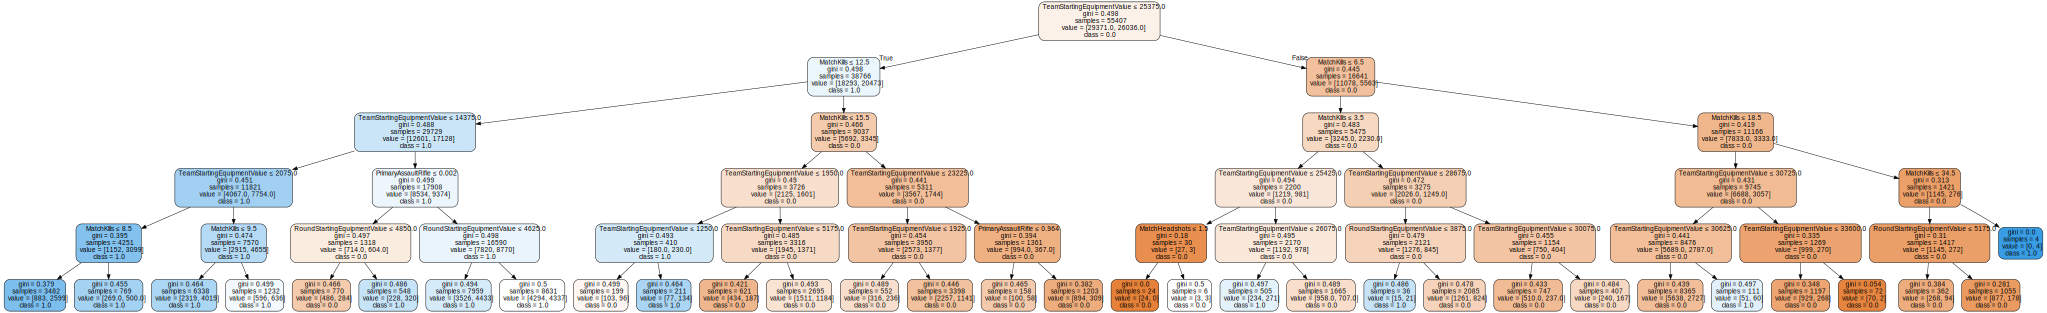

In [22]:
# Let's try predicting 'MatchWinner' based on the specified features.
features_clf = ['MatchHeadshots', 'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'PrimaryAssaultRifle', 'MatchKills'] # Added MatchKills as a potential feature
target_clf = 'MatchWinner' # Changed target variable

# Ensure the target variable is appropriate for classification (e.g., object or category)
# And ensure features are numeric
df_model_clf = df[features_clf + [target_clf]].copy()

# Handle potential missing values
df_model_clf = df_model_clf.dropna()

# Convert 'PrimaryAssaultRifle' to numeric if it's not already
df_model_clf['PrimaryAssaultRifle'] = pd.to_numeric(df_model_clf['PrimaryAssaultRifle'], errors='coerce')
df_model_clf = df_model_clf.dropna() # Drop rows where conversion failed

# Convert the target variable to a categorical type if it's not already
df_model_clf[target_clf] = df_model_clf[target_clf].astype('category')


X_clf = df_model_clf[features_clf]
y_clf = df_model_clf[target_clf]

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

# Create a Decision Tree Classifier model
model_clf = DecisionTreeClassifier(random_state=42, max_depth=5) # Changed to DecisionTreeClassifier

# Train the model
model_clf.fit(X_train_clf, y_train_clf)

# Visualize the classification tree
dot_data_clf = tree.export_graphviz(model_clf, out_file=None,
                     feature_names=features_clf,
                     class_names=[str(c) for c in model_clf.classes_], # Include class names for visualization
                     filled=True, rounded=True,
                     special_characters=True)
graph_clf = graphviz.Source(dot_data_clf)

# To display in notebook:
graph_clf

##Métricas Binarias

Accuracy:  0.6142
Precision (weighted): 0.6201
Recall (weighted):    0.6142
F1 Score (weighted):  0.6140

Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.57      0.61     12645
         1.0       0.58      0.66      0.62     11102

    accuracy                           0.61     23747
   macro avg       0.62      0.62      0.61     23747
weighted avg       0.62      0.61      0.61     23747


Confusion Matrix:
[[7224 5421]
 [3741 7361]]

Per-class Accuracy:
Clase 0: 0.5713
Clase 1: 0.6630

Cross-validation Results:
Fold Accuracies:  [0.62080728 0.60444697 0.60154128 0.62819784 0.61541377]
Fold ROC AUCs:    [0.65856926 0.64105152 0.63911178 0.66729416 0.64741855]

Accuracy CV Mean ± Std: 0.6141 ± 0.0100
ROC AUC CV Mean ± Std:  0.6507 ± 0.0107


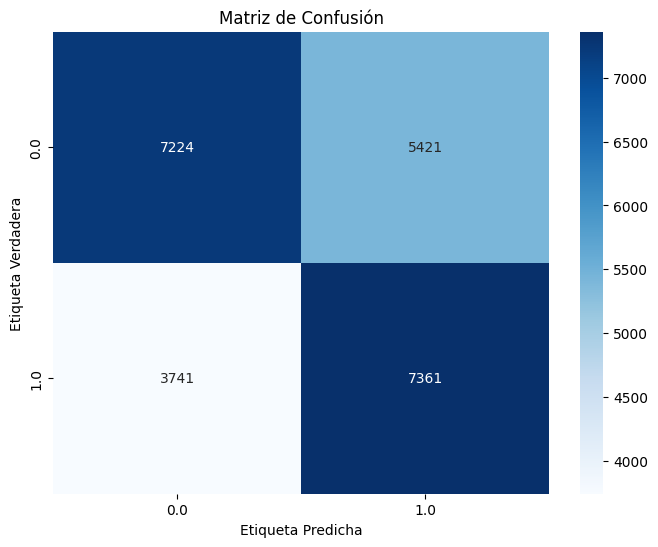

In [60]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.model_selection import cross_validate
import numpy as np

# -------------------------------------
# 1. Predicciones y métricas básicas
# -------------------------------------
y_pred = model_clf.predict(X_test_clf)

accuracy = accuracy_score(y_test_clf, y_pred)
precision = precision_score(y_test_clf, y_pred, average='weighted')
recall = recall_score(y_test_clf, y_pred, average='weighted')
f1 = f1_score(y_test_clf, y_pred, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted):    {recall:.4f}")
print(f"F1 Score (weighted):  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred))

cm = confusion_matrix(y_test_clf, y_pred)
print("\nConfusion Matrix:")
print(cm)

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for idx, acc in enumerate(per_class_accuracy):
    print(f"Clase {idx}: {acc:.4f}")

# -------------------------------------
# 2. Validación cruzada
# -------------------------------------
scoring = ['accuracy', 'roc_auc']  # Ajustar según problema (binario/multiclase)
cv_results = cross_validate(
    model_clf,
    X_clf,
    y_clf,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

print("\nCross-validation Results:")
print("Fold Accuracies: ", cv_results['test_accuracy'])
print("Fold ROC AUCs:   ", cv_results['test_roc_auc'])

print(f"\nAccuracy CV Mean ± Std: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"ROC AUC CV Mean ± Std:  {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_clf.classes_, yticklabels=model_clf.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


# Realizar Prediccion

In [59]:
# Datos del nuevo partido (ejemplo)
new_match = {
    'MatchHeadshots': 25,
    'RoundStartingEquipmentValue': 8500,
    'TeamStartingEquipmentValue': 34000,
    'PrimaryAssaultRifle': 3,
    'MatchKills': 30
}

# Convertir a DataFrame
new_match_df = pd.DataFrame([new_match])

# Hacer predicción
predicted_winner = model_clf.predict(new_match_df)
predicted_proba = model_clf.predict_proba(new_match_df)

# Obtener índice de la clase predicha
pred_class_idx = list(model_clf.classes_).index(predicted_winner[0])
confidence = predicted_proba[0][pred_class_idx] * 100  # porcentaje

# Interpretar y mostrar resultado claro con confianza
if predicted_winner[0]:
    resultado = f"¡El modelo predice que el equipo GANARÁ el partido con un {confidence:.2f}% de confianza!"
else:
    resultado = f"El modelo predice que el equipo PERDERÁ el partido con un {confidence:.2f}% de confianza."

print("===== Resultado de la Predicción =====")
print(f"Con las siguientes características del partido:\n{new_match}\n")
print(resultado)
print("======================================")


===== Resultado de la Predicción =====
Con las siguientes características del partido:
{'MatchHeadshots': 25, 'RoundStartingEquipmentValue': 8500, 'TeamStartingEquipmentValue': 34000, 'PrimaryAssaultRifle': 3, 'MatchKills': 30}

El modelo predice que el equipo PERDERÁ el partido con un 83.13% de confianza.
